In [15]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
 

import warnings
warnings.filterwarnings('ignore')

In [46]:
import math
import librosa.display
import random

In [4]:
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise


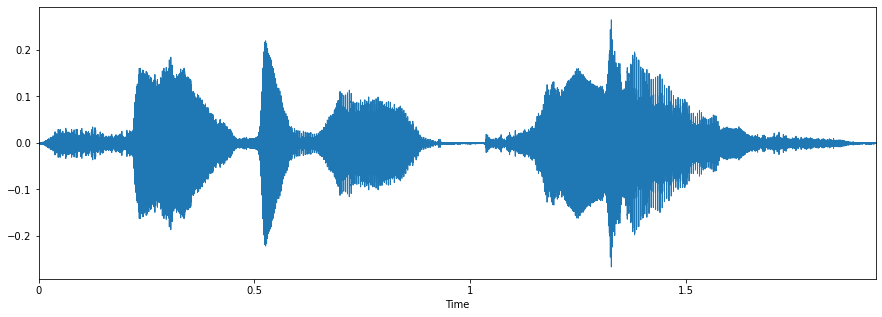

In [85]:
emotions = 'disgust fear neutral angry sad happy surprise'.split()
emotion = random.choice(emotions)
fn = random.choice(os.listdir(f'D:/Competitons/Enigma_tech_tatva/Dr Sheldon Cooper/Dr Sheldon Cooper/Train/{emotion}'))
audio = f'D:/Competitons/Enigma_tech_tatva/Dr Sheldon Cooper/Dr Sheldon Cooper/Train/{emotion}/{fn}'
data, sampling_rate = librosa.load(audio)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

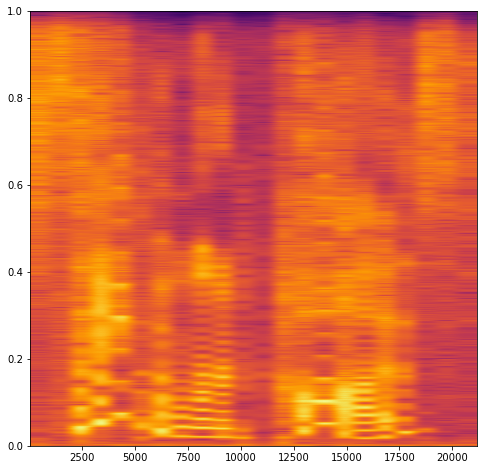

In [86]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
plt.specgram(data, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');

In [66]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
header

['filename',
 'chroma_stft',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [7]:
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
emotions = 'disgust fear neutral angry sad happy surprise'.split()
for e in emotions:
    for filename in os.listdir(f'D:/Competitons/Enigma_tech_tatva/Dr Sheldon Cooper/Dr Sheldon Cooper/Train/{e}'):
        emoname = f'D:/Competitons/Enigma_tech_tatva/Dr Sheldon Cooper/Dr Sheldon Cooper/Train/{e}/{filename}'
        y, sr = librosa.load(emoname, mono=True, duration=30)
        y=np.interp(y, (y.min(), y.max()), (-1, 1))
        noise, sr = librosa.load('noise.wav')
        noise=np.interp(noise, (noise.min(), noise.max()), (-1, 1))

        if(len(noise)>len(y)):
            noise=noise[0:len(y)]

        noise=get_noise_from_sound(y,noise,SNR=10)
        try:
            y= y + noise
        except ValueError:
            continue
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for f in mfcc:
            to_append += f' {np.mean(f)}'
        to_append += f' {e}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [96]:
data = pd.read_csv('dataset.csv')
data.head(10)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
disgust,(1).wav,0.384857,0.166697,5170.101337,3883.851676,9508.666992,0.119768,-178.942209,15.589706,63.552269,...,4.482245,-1.083988,10.505644,-1.967378,3.096455,-1.560278,5.896125,1.359314,1.318534,disgust
disgust,(10).wav,0.354562,0.180473,5145.648299,3738.871199,9378.632812,0.093522,-172.843920,-0.958225,44.809595,...,4.353952,1.448012,10.670916,-2.527099,3.413903,-0.029795,7.144682,-0.192049,3.569114,disgust
disgust,(100).wav,0.291940,0.267209,4908.519187,4020.967677,9556.763226,0.108563,-138.884865,19.058779,69.594846,...,-2.920450,-6.906878,7.754331,-0.467433,4.848597,-1.759331,5.153526,0.796092,1.141290,disgust
disgust,(101).wav,0.298704,0.252298,5137.358337,4060.535617,9608.407919,0.083894,-171.455961,2.672009,71.427761,...,-0.973744,-5.242580,6.587219,-2.827021,3.420814,-4.441741,3.538313,1.266793,2.349872,disgust
disgust,(102).wav,0.288625,0.181834,5127.990376,3835.452320,9432.440186,0.151702,-173.532671,6.922281,62.341625,...,-0.823678,-5.432270,7.746665,-2.115983,1.495594,-3.477185,4.369208,-0.356374,3.053647,disgust
disgust,(103).wav,0.291671,0.271418,5076.518334,3954.543902,9478.162354,0.097593,-158.473654,9.998194,72.630308,...,-0.867852,-5.761257,11.769651,0.852477,3.719323,-1.996368,4.952957,0.195213,2.144776,disgust
disgust,(104).wav,0.287005,0.193979,4883.959281,3966.522711,9469.555664,0.133555,-166.288291,23.285767,68.065577,...,-0.406480,-7.508821,8.042753,-4.473842,0.840556,-3.152435,2.615279,0.631815,4.079903,disgust
disgust,(105).wav,0.349189,0.208588,4975.484829,3864.052966,9563.636435,0.123651,-133.209227,17.403370,39.345607,...,0.569869,-4.636458,11.226002,-0.373431,2.038567,-1.499508,5.370411,1.707588,3.725743,disgust
disgust,(106).wav,0.337767,0.216235,5313.118420,3904.483275,9643.615387,0.087622,-159.744950,-0.400694,58.086162,...,3.756179,-0.749162,11.257097,1.398261,5.903928,-0.117168,4.483257,1.499310,5.376238,disgust
disgust,(107).wav,0.309285,0.229756,5008.332595,3877.242313,9386.215576,0.109326,-155.991554,10.712526,64.461041,...,-0.735420,-4.362195,7.298596,-3.797629,4.010792,-1.286189,3.970813,0.057440,3.441074,disgust


In [81]:

data.fillna(method='ffill',inplace=True)# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
dicti = {'disgust':int(1),'fear':int(2),'neutral':int(3),'angry':int(4),'sad':int(5),'happy':int(6),'surprise':int(7)}#Encoding the Labels
data.replace({"label": dicti},inplace=True) 
emo_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = data['label']
# y_train = encoder.fit_transform(emo_list)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
# y_train.unique()


disgust     1
disgust     1
disgust     1
disgust     1
disgust     1
           ..
surprise    7
surprise    7
surprise    7
surprise    7
surprise    7
Name: label, Length: 3593, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

In [30]:
X_train.shape[0]

2515

In [97]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               6912      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
__________________________________________________

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train,y_train,epochs=100,batch_size=128)

Epoch 1/100
20/20 [==============================] - 0s 7ms/step - loss: 1.7637 - accuracy: 0.4318
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.0413 - accuracy: 0.6636
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.7656 - accuracy: 0.7384
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6712 - accuracy: 0.7602
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6151 - accuracy: 0.7750
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5679 - accuracy: 0.7944
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5428 - accuracy: 0.8024
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5126 - accuracy: 0.8087
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.5050 - accuracy: 0.8131
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4848 - accuracy: 0.8258
Epoch 11/

20/20 [==============================] - 0s 7ms/step - loss: 0.0758 - accuracy: 0.9757
Epoch 84/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0881 - accuracy: 0.9686
Epoch 85/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0786 - accuracy: 0.9746
Epoch 86/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0743 - accuracy: 0.9765
Epoch 87/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.9777
Epoch 88/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.9769
Epoch 89/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 90/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 0.9837
Epoch 91/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0709 - accuracy: 0.9746
Epoch 92/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.9825
Epoch 93/100


In [38]:
y_pred = model.predict_classes(X_test)
eval = model.evaluate(X_test,y_test)
eval

34/34 [==============================] - 0s 3ms/step - loss: 0.4893 - accuracy: 0.8933


[0.4892708957195282, 0.8933209776878357]

In [41]:
print('Model Accuracy: {:.2f}%'.format(eval[1]))

Model Accuracy: 0.89%


In [58]:
prediction = pd.DataFrame(y_pred,columns = ['emotion'])
emo_dict={1:'disgust',2:'fear',3:'neutral',4:'angry',5:'sad',6:'happy',7:'surprise'}
prediction.replace(emo_dict,inplace=True)
prediction.head(10)

,emotion
0,surprise
1,sad
2,neutral
3,happy
4,sad
5,fear
6,fear
7,angry
8,neutral
9,neutral
